In [117]:
# Data handling
import pandas as pd
import numpy as np
from scipy.signal.windows import gaussian
# Visualisation
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Misc
import requests
import json
from datetime import datetime, timedelta

In [20]:
df = pd.read_json("data/results.json")

In [22]:
df

,url,rated,time_class,time_control,timestamp,played,rating,opponent,opponent_rating,result,info
0,https://www.chess.com/game/daily/117204770,True,daily,1/259200,2015-08-27 09:21:49,white,1296,RadioActiveRabbit,904,win,resigned
1,https://www.chess.com/game/daily/117271926,True,daily,1/86400,2015-08-28 14:14:05,black,1391,sam-marsh,1078,win,checkmated
2,https://www.chess.com/game/daily/117210408,True,daily,1/86400,2015-08-27 12:13:37,black,1417,RadioActiveRabbit,873,win,resigned
3,https://www.chess.com/game/daily/117310578,False,daily,1/86400,2015-08-29 06:21:08,white,1417,RadioActiveRabbit,873,win,resigned
4,https://www.chess.com/game/daily/117889282,False,daily,1/86400,2015-09-07 02:13:30,black,1200,RadioActiveRabbit,1000,loss,resigned
...,...,...,...,...,...,...,...,...,...,...,...
4231,https://www.chess.com/game/live/43814076047,True,rapid,600,2022-04-16 02:14:40,black,1388,Kratos10ars,1381,loss,resigned
4232,https://www.chess.com/game/live/43817050989,True,rapid,600,2022-04-16 03:04:15,white,1380,panzon23,1414,loss,resigned
4233,https://www.chess.com/game/live/43817106827,True,rapid,600,2022-04-16 03:12:49,black,1387,alanedwardoconnor,1330,win,checkmated
4234,https://www.chess.com/game/live/43827276243,True,rapid,600,2022-04-16 05:55:13,black,1379,levisarrechia4283,1415,loss,resigned


## What do I want to know?
What game styles have I played the most?
What is the break down of my wins per color?

What time of day do I play most often?
What time of day do I win most often?

What range of players do I tend to win against?

Plot the timeline of my chess score for each style of game.

## Plot the distribution of games over time using a moving average.

In [157]:
daily_games = df[["time_class", "timestamp"]].reset_index(drop=True)
daily_games["date"] = pd.to_datetime(daily_games["timestamp"].dt.date)
daily_games = daily_games[["time_class", "date", "timestamp"]].groupby(["time_class", "date"]).agg("count").reset_index()
daily_games = daily_games.rename(columns={"timestamp": "games_played"})


# Fill in the average games over empty periods of time
start_date = daily_games["date"].min()
end_date = datetime.today()
date_master = pd.DataFrame(pd.date_range(start_date, end_date), columns=["date"])

game_types = daily_games["time_class"].drop_duplicates()
master = date_master.merge(game_types, how="cross")

daily_games = master.merge(daily_games, on=["date", "time_class"], how="left")
daily_games = daily_games.fillna(0)

# Perform a rolling window average
windows = [7, 30, 60, 90] # days
for window in windows:
    temp = daily_games.groupby('time_class')["games_played"].rolling(
        window, 
        min_periods=1, 
        center=True,
        win_type='triang'
    ).mean()
    daily_games[f"mean_games_{window}"] = temp.reset_index(0,drop=True)

daily_games.head(10)

,date,time_class,games_played,mean_games_7,mean_games_30,mean_games_60,mean_games_90
0,2015-08-27,blitz,0.0,0.000000,0.000000,0.000000,0.000000
1,2015-08-27,daily,2.0,1.000000,0.600000,0.466667,0.377778
2,2015-08-27,rapid,0.0,0.000000,0.000000,0.000000,0.000000
3,2015-08-28,blitz,0.0,0.000000,0.000000,0.000000,0.000000
4,2015-08-28,daily,1.0,0.800000,0.625000,0.451613,0.369565
5,2015-08-28,rapid,0.0,0.000000,0.000000,0.000000,0.000000
6,2015-08-29,blitz,0.0,0.000000,0.000000,0.000000,0.000000
7,2015-08-29,daily,1.0,0.666667,0.588235,0.437500,0.361702
8,2015-08-29,rapid,0.0,0.000000,0.000000,0.000000,0.000000
9,2015-08-30,blitz,0.0,0.000000,0.000000,0.000000,0.000000


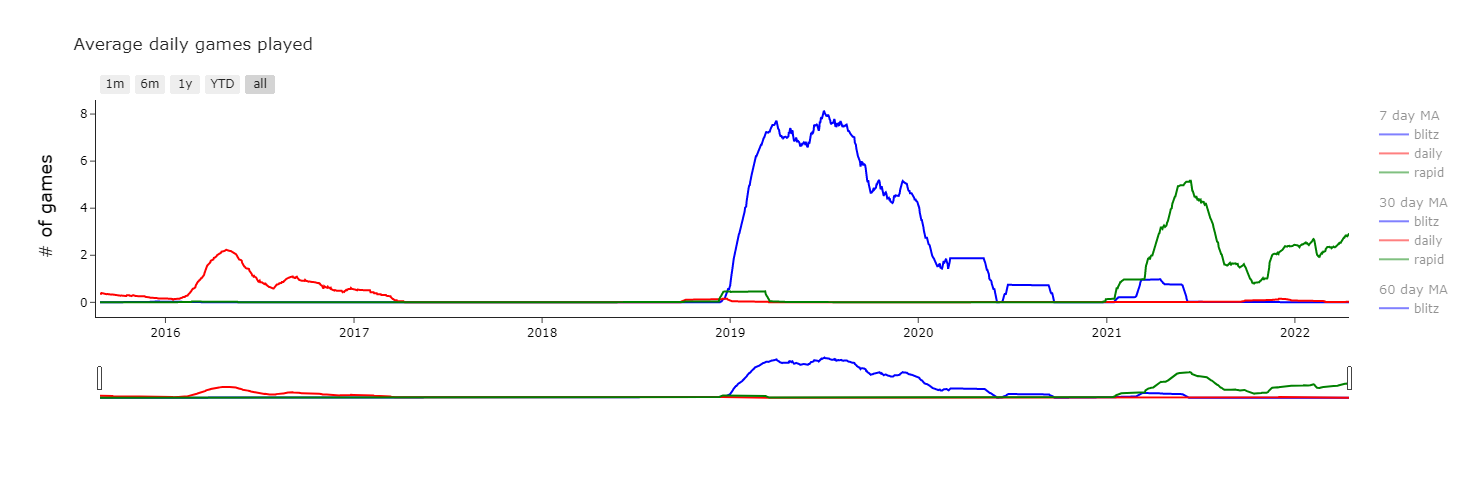

In [158]:
# Plot data
fig = go.Figure()

colors = ["blue", "red", "green"]

for window in windows:
    
    for gg, game_type in enumerate(game_types.unique()):
    
        games = daily_games[(daily_games["time_class"]==game_type)]

        fig.add_trace(go.Scatter(
            x=games["date"], 
            y=games[f"mean_games_{window}"], 
            name=f"{game_type}",
            line=dict(color=colors[gg]),
            legendgroup=f"{window} day MA",
            legendgrouptitle_text=f"{window} day MA",
            visible=True if window == 90 else "legendonly"
            ),
        )

fig.update_layout(
    template="simple_white",
    title=f"Average daily games played",
    autosize=False,
    width=1000,
    height=500,
    margin=dict(
        l=100,
        r=100,
        b=100,
        t=100,
        pad=4
    ),
)

fig.update_yaxes(
    title="# of games",
    title_font=dict(size=18, color='black'), 
    tickfont=dict(color="black")
)

fig.update_xaxes(
    tickfont=dict(color="black"),
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=6, label="1y", step="year", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(step="all")
        ])
    )
)

fig.show()

In [159]:
daily_games[(daily_games["time_class"]=="blitz")&(daily_games["date"]>datetime(2020,8,1))].head(49)

,date,time_class,games_played,mean_games_7,mean_games_30,mean_games_60,mean_games_90
5406,2020-08-02,blitz,0.0,5.714286,2.233333,1.116667,0.744444
5409,2020-08-03,blitz,8.0,5.571429,2.233333,1.116667,0.744444
5412,2020-08-04,blitz,13.0,5.000000,2.233333,1.116667,0.744444
5415,2020-08-05,blitz,9.0,5.000000,2.233333,1.116667,0.744444
5418,2020-08-06,blitz,5.0,5.000000,2.233333,1.116667,0.744444
5421,2020-08-07,blitz,0.0,3.857143,2.233333,1.116667,0.744444
5424,2020-08-08,blitz,0.0,2.000000,2.233333,1.116667,0.744444
5427,2020-08-09,blitz,0.0,0.714286,2.233333,1.116667,0.744444
5430,2020-08-10,blitz,0.0,0.000000,2.233333,1.116667,0.744444
5433,2020-08-11,blitz,0.0,0.000000,2.166667,1.116667,0.744444
